### **Generation and Manipulation of faces using Generative Adversarial Networks**
*Project for CSCI 630 - Foundations of Artificial Intelligence* 

---


*   [Aishwarya Rao](ar2711@rit.edu)
*   [Rishabh Manish Sahlot](rs3655@rit.edu)
*   [Anuj Kulkarni](ak8285@rit.edu)
*   [Shweta Vijay Wahane](sw9910@rit.edu)

The following notebook uses conditional  generative  ad-versarial  networks  to  generate  realistic  images  of faces based age.

In [0]:
#Import statements
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import cv2
import dlib 
import os 
import scipy.misc
import numpy as np
from tqdm import tqdm 
import pickle
import random
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [0]:
#Generator component for conditional GAN - takes in face embedding and age condition as input
#Produces a 64x64 grayscale image
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #Encode condition into a 1024 vector before feeding into convolutoion layers
        self.encoding = nn.Sequential(nn.Linear(128+24, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True))
        self.model = nn.Sequential( 
            nn.ConvTranspose2d(1024, 64*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64* 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64* 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64* 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 128).float() #size - batchsize x 128
        c = labels.view(labels.size(0),24).float() #size - batchsize x 24
        x = torch.cat([z, c], 1)
        x= x.view(x.size(0), 152) #after concat - batchsize x (128+24)
        x = self.encoding(x.float()) #Encode condition before convolution model
        x = x.view(x.size(0), 1024, 1,1)
        out = self.model(x.float())
        
        return out

generator = Generator().cuda()       
#Generator model and weights
downloaded = drive.CreateFile({'id':"1ybC6ZIl1oJTArfKPyfIA1F76GfOlz9DH"})   
downloaded.GetContentFile('generator.pt')

generator.load_state_dict(torch.load("generator.pt"))
generator.eval()

Generator(
  (encoding): Sequential(
    (0): Linear(in_features=152, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64,

In [0]:
#Face recognition model to obtain embeddings from every face in dataset
downloaded = drive.CreateFile({'id':"1XLHHUD3qMEk2i8SEVoIOvgR3cDQCeR1q"})   
downloaded.GetContentFile('dlib_face_recognition_resnet_model_v1.dat.bz2')
# Landmark generator from dlib to identify facial landmarks
# Facial Landmarks are used by the dlib face recognition model
downloaded = drive.CreateFile({'id':"1Q7Bj4YRpIXU2WF5zrUbJe3AazUGi0lCt"})   
downloaded.GetContentFile('shape_predictor_68_face_landmarks.dat.bz2')
#Extract these for use 
!bzip2 dlib_face_recognition_resnet_model_v1.dat.bz2 --decompress
!bzip2 shape_predictor_68_face_landmarks.dat.bz2 --decompress

def get_dlib_embeddings(image):
    '''
    Takes in image, (grayscale)
    returns 128 dimension facial embedding using the dlib face recognition model
    '''
    
    face_detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    face_recognition_model = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')
    
    #Detect face position
    detected_faces = face_detector(image, 1)
    #Extract landmarks for every face detected - in this case, only one face is present
    shapes_faces = [shape_predictor(image, face) for face in detected_faces]
    #Return embedding of the face using face recognition model
    return [np.array(face_recognition_model.compute_face_descriptor(image, face_pose, 1)) for face_pose in shapes_faces]

def convert_age(age):
    onehot = [0]*24
    onehot[age//5]=1
    return onehot

def preprocess_image(imagepath):
  image = cv2.imread(imagepath)
  image = cv2.resize(image, (64,64))
  return image



bzip2: Output file dlib_face_recognition_resnet_model_v1.dat already exists.
bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


Enter path to image - age80-real.png
Enter desired age - 24


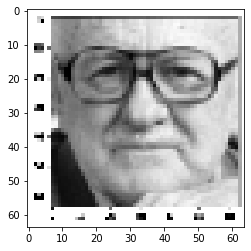

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:362: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


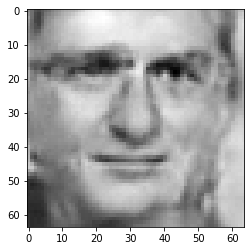

In [0]:
#Upload image to Google Colab and give path to image before running
imagepath = input("Enter path to image - ")
age = input("Enter desired age - ")

image = preprocess_image(imagepath)
plt.imshow(image, cmap="gray")
plt.show()
age = convert_age(int(age))
encodings = get_dlib_embeddings(image)

#convert to batch size of 1
age = torch.Tensor(np.asarray([age])).cuda()
encodings = torch.Tensor(np.asarray([encodings])).cuda()
output = generator(encodings, age).unsqueeze(1).data.cpu()
output= output.resize(64,64)
output = np.asarray(output, dtype="float32")*255
plt.imshow(output, cmap="gray")
plt.show()